In [168]:
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from scipy.integrate import simps

In [186]:
# start = 0.4
# end = 9.6
# dx = 0.4
# num_values = int((end - start) / dx) + 1
# impact_parameters = np.linspace(start, end, num_values)
projectile_mass = 1836 # mass of proton in au (really 1/mass e-)
impact_parameters = [round(i * 0.4, 1) for i in range(7,8)]
print(impact_parameters)
momentum = np.array([10, 25, 50, 100, 200]) * 27.21e-3 * projectile_mass * -1 # kev to au  
velocity = -momentum / projectile_mass
distance = 60
print(momentum)
print(velocity)
input_file = 'in_3D.dat'
code_executable = './fd_3D.x'

[2.8]
[ -499.5756 -1248.939  -2497.878  -4995.756  -9991.512 ]
[0.2721  0.68025 1.3605  2.721   5.442  ]


In [177]:
def update_b(line, new_b):
    values = line.strip().split(' ') #splitting line by space
    values[0] = f"{new_b}d0" # impact parameter 
    return ' '.join(values) + '\n' # putting vals back in line 

In [178]:
def update_momentum(line, new_p):
    values = line.strip().split(' ') #splitting line by space
    values[-1] = f"{new_p}d0" # last value which is velocity
    return ' '.join(values) + '\n' # putting vals back in line 

In [179]:
def update_time(line, new_p):
    new_v = -new_p / projectile_mass
    time = distance / new_v
    values = line.strip().split(' ') #splitting line by space
    values[2] = f"{time}d0" # last value which is velocity
    return ' '.join(values) + '\n' # putting vals back in line

In [180]:
def list_files_in_directory(directory):
    files = os.listdir(directory)
    return files

In [184]:
def run_code():
    for b in impact_parameters: 
        with open(input_file, 'r') as file:
            lines = file.readlines()  # read file
        
        lines[19] = update_b(lines[19], b) # update b

        with open(input_file, 'w') as file:
            file.writelines(lines) # update file  

        os.makedirs(f'b={b}', exist_ok=True)

        for p in momentum:
            energy = round(p / (27.21e-3 * projectile_mass * -1),1)
            edir = os.path.join(f'b={b}', f'{energy}keV')
            os.makedirs(edir, exist_ok=True)

            lines[1] = update_time(lines[1], p) # update time 
            lines[25] = update_momentum(lines[25], p)

            with open(input_file, 'w') as file:
                file.writelines(lines) # update file  
            
            with open(input_file, 'r') as f:
                result = subprocess.run([code_executable], stdin=f, capture_output=True, text=True, check=True)
            
            for filename in os.listdir("."):
                if filename.startswith("fort."): 
                    try:
                        shutil.move(filename, edir)  
                    except shutil.Error:
                        pass

In [187]:
run_code()

In [ ]:
def gen_cross_section(): # electron capture cross section 
    for b in impact_parameters:
        for p in momentum:
            energy = round(p / (27.21e-3 * projectile_mass * -1),1)
            directory_path = os.path.join(f'b={b}', f'{energy}keV')
            files_in_directory = list_files_in_directory(directory_path)

            x_vals = []
            y_vals = []

            for file_name in files_in_directory:
                if file_name == "fort.1000":
                    file_path = os.path.join(directory_path, file_name)
                    with open(file_path, 'r') as file:
                        lines = file.readlines()
                        for line in lines:
                            x, y = map(float, line.strip().split())  # Split and convert to float
                            x_vals.append(x)
                            y_vals.append(y)

            x_vals_to_int = []
            y_vals_to_int = []
                
            for i, x in enumerate(x_vals):
                if x <= -15:
                    x_vals_to_int.append(x)
                    y_vals_to_int.append(y_vals[i])
            
        #     cross_section = 

        # yield cross_section 


In [ ]:
def get_result():
    Vavgs = []
    Tavgs = []

    for b in impact_parameters: 
        with open(input_file, 'r') as file:
            lines = file.readlines()  # read file
        
        lines[19] = update_b(lines[19], b) # update b

        with open(input_file, 'w') as file:
            file.writelines(lines) # update file  
        
        with open(input_file, 'r') as f:
            result = subprocess.run([code_executable], stdin=f, capture_output=True, text=True, check=True)

        stdout_lines = result.stdout.split('\n')
        output_lines = "\n".join(stdout_lines[1:-1])

        Vavg = ",".join(line.strip().split()[3] for line in stdout_lines[1:-1])
        Vavg_split = Vavg.split(',')
        Tavg = ",".join(line.strip().split()[2] for line in stdout_lines[1:-1])
        Tavg_split = Tavg.split(',')
        time = ",".join(line.strip().split()[0] for line in stdout_lines[1:-1])

        Vavgs.append(Vavg_split)
        Tavgs.append(Tavg_split)

        # print(f"b = {b}", 'time:', time, 'Tavg:', Tavg, 'Vavg:', Vavg)
    
    float_v = [[float(item) for item in sublist] for sublist in Vavgs]
    float_t = [[float(item) for item in sublist] for sublist in Tavgs]
    s = time.split(',')
    float_time = [float(item) for item in s]

    return float_v, float_t, float_time
        

In [ ]:
Vavgs, Tavgs, time = get_result()

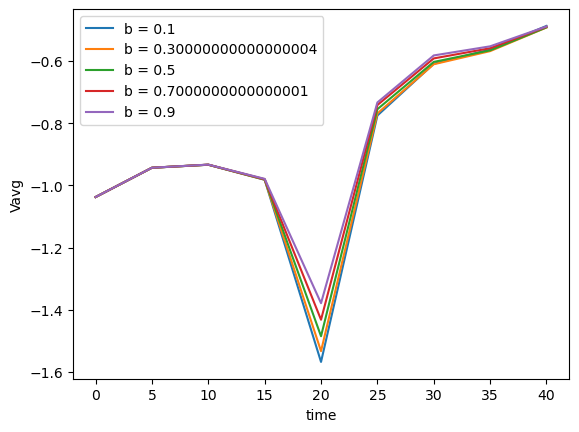

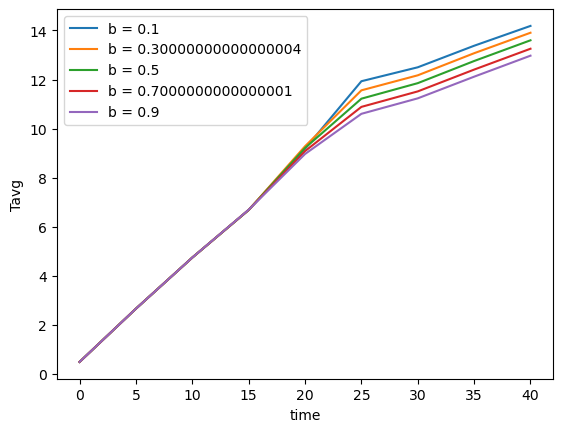

In [ ]:
for i, b in enumerate(impact_parameters):
    plt.plot(time, Vavgs[i], label = f'b = {b}')
    plt.ylabel('Vavg')
    plt.xlabel('time')
    plt.legend()
plt.show()

for i, b in enumerate(impact_parameters):
    plt.plot(time, Tavgs[i], label = f'b = {b}')
    plt.ylabel('Tavg')
    plt.xlabel('time')
    plt.legend()
plt.show()

